# Dropping of irrelevant or sparse columns

The main goal of this notebook is to deal with missing values in the dataset, that forbid us to perform most of machine learning algorithms.

We'll first import the database and get rid of some columns that only contain one value (thus providing no information whatsoever).
We'll then drop columns that present more than 65% missing values (the threshold of 65% being chosen so that genetic variables, with a missing values ratio of 64%, are not overlooked).

## Libraries imports

In [1]:
# Basic imports
import pandas as pd
import numpy as np

# Import to find the wave related to each variable
import re

# Imports to impute missing values
from sklearn.impute import SimpleImputer
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

## Data import

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Statapp/data_without_AE.csv")

<ipython-input-2-43685240b1fa>:1: DtypeWarning: Columns (1379,1380,1382,1388,1391,15103) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Statapp/data_without_AE.csv")


In [3]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 15104 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(14977), int64(111), object(16)
memory usage: 4.8 GB


In [4]:
data.head()

,HHIDPN,S1HHIDPN,R1MSTAT,R1MPART,S1BMONTH,S1BYEAR,S1BDATE,S1BFLAG,S1COHBYR,S1HRSAMP,...,genetic_4_PP_COGENT17,genetic_4_SBP_COGENT17,genetic_4_EGFR_CKDGEN19,genetic_4_EGFRTE_CKDGEN19,genetic_4_EA3_W23_SSGAC18,genetic_4_HBA1CAA_MAGIC17,genetic_4_HBA1CEA_MAGIC17,genetic_4_GCOG2_CHARGE18,genetic_VERSION,genetic_Section_A_or_E
0,1010,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,3020.0,1.0,0.0,9.0,1938.0,-7778.0,0.0,3.0,1.0,...,-0.58662,-0.66936,1.04423,1.02390,1.53372,0.47688,-1.28083,-1.51568,4.3,E
3,3020,3010.0,1.0,0.0,1.0,1936.0,-8752.0,0.0,3.0,1.0,...,-0.06204,-0.70205,-1.06050,-1.08282,0.85439,-0.62488,-1.29031,0.40118,4.3,E
4,10001010,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Drop columns corresponding to the spouse of the respondent

A first glance at the database show that variables mainly concern the respondent (variable name starts with an 'R'), his spouse (variable name starts with an 'S') or his household (variable name starts with an 'H').

In [5]:
starting_characters = {}
other_columns = []
for col in data.columns:
  if col[1] in "123456789":
    if col[0] not in starting_characters.keys():
      starting_characters[col[0]] = 1
    else:
      starting_characters[col[0]] += 1
  else:
    other_columns.append(col)

print(f"Dataset has {data.shape[1]} columns, of which:\n >>> {len([col for col in data.columns if 'genetic_' in col])} are genetic variables;\n >>> {sum(starting_characters.values())} start with a character in {starting_characters}.")
print("Here are the other columns:\n" + str(other_columns))

Dataset has 15104 columns, of which:
 >>> 85 are genetic variables;
 >>> 14684 start with a character in {'S': 7165, 'R': 6614, 'H': 905}.
Here are the other columns:
['HHIDPN', 'INW1', 'INW2', 'INW3', 'INW4', 'INW5', 'INW6', 'INW7', 'INW8', 'INW9', 'INW10', 'INW11', 'INW12', 'INW13', 'INW14', 'RASPID1', 'RASPID2', 'RASPID3', 'RASPID4', 'RASPCT', 'RAOAHDID', 'RAOHRSID', 'HHID', 'RAOVRLAP', 'HACOHORT', 'RAGENDER', 'RAHISPAN', 'RARACEM', 'RABMONTH', 'RABYEAR', 'RABDATE', 'RABFLAG', 'RADMONTH', 'RADYEAR', 'RADDATE', 'RADSRC', 'RADTIMTDTH', 'RADAGE_M', 'RADAGE_Y', 'RAEDYRS', 'RAEDEGRM', 'RAEDUC', 'RABPLACF', 'RARELIG', 'RAVETRN', 'RAMEDUC', 'RAFEDUC', 'RABPLACE', 'REXITWV', 'REPEXITWV1', 'REPEXITWV2', 'REPEXITWV3', 'RAWTSAMP', 'RAESTRAT', 'RAEHSAMP', 'RAAHDSMP', 'RAHRSAMP', 'RACOHBYR', 'RAHHIDPN', 'HAOAHDHH', 'RAOVRAYR', 'PN', 'REXITYR', 'REPLDEATH', 'REXPDEATH', 'RET2DEATH', 'RECENDIV', 'RECENREG', 'REPROXYSP', 'REPROXYREL', 'RESHHIDPN', 'REMSTAT', 'REMPART', 'REMSTATH', 'REIWBEG', 'REIWM

In [6]:
columns_spouse = [col for col in data.columns if col[0] == "S" and col[1] in "123456789"]

In [7]:
# Spouses who also are respondents
list_of_spouses = set()
for wave in range(1, 15):
  wave_spouses = set(data[f"S{wave}HHIDPN"].dropna().unique())
  list_of_spouses.update(wave_spouses)

count=0
for spouse in list_of_spouses:
  if spouse in data["HHIDPN"].values:
    count+=1

print(f"Among the {len(list_of_spouses)} spouses, {count} of them also happen to be respondents.")

Among the 31655 spouses, 30272 of them also happen to be respondents.


We see that among the 31655 spouses, 30272 are also respondents. This means that at the cost of 1383 individuals, we can delete 7165 columns.

We shall then proceed.

In [8]:
data = data.drop(columns = columns_spouse)


In [9]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 7939 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(7812), int64(111), object(16)
memory usage: 2.5 GB


## Track temporal variables and delete sparse columns

We want to delete columns with a missing values rate too high.

If we happened to just count the number of missing values in each row without any further consideration, we would miss the fact that some values are missing not because they were not recorded, but because it would make no sense for them to be.

To avoid this problem, we will check, when a value is missing, if the respondent had been interviewed during the considered wage or not: if he hasn't been interviewed, then we don't take the related missing values in consideration.

In [10]:
# We check how many waves are available in the database.
for col in data.columns:
  if "INW" in col:
    print(col, end=" ; ")

INW1 ; INW2 ; INW3 ; INW4 ; INW5 ; INW6 ; INW7 ; INW8 ; INW9 ; INW10 ; INW11 ; INW12 ; INW13 ; INW14 ; 

wave 1: 392 ; overall: 392
wave 2: 505 ; overall: 897
wave 3: 504 ; overall: 1401
wave 4: 574 ; overall: 1975
wave 5: 533 ; overall: 2508
wave 6: 559 ; overall: 3067
wave 7: 560 ; overall: 3627
wave 8: 583 ; overall: 4210
wave 9: 591 ; overall: 4801
wave 10: 610 ; overall: 5411
wave 11: 602 ; overall: 6013
wave 12: 586 ; overall: 6599
wave 13: 601 ; overall: 7200
wave 14: 590 ; overall: 7790


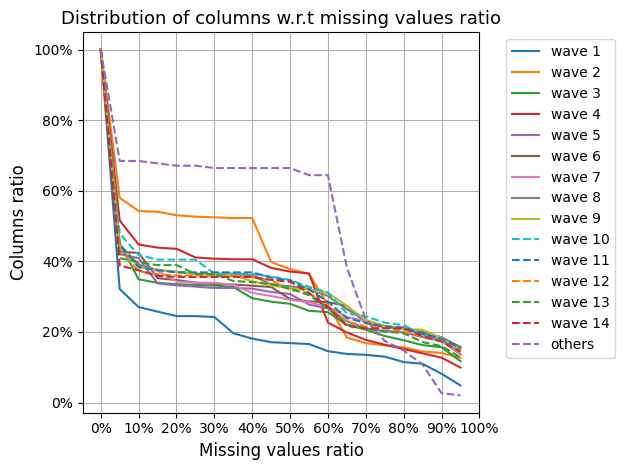

In [11]:
# To explore with more details the number of columns with a given missing values rate, we will plot the associated curve.
def count_columns(missing_values_thresholds, data):
  """
  Return a numpy array with, for each threshold, the number of columns in 'data'
  that present a missing values rate greater than 'threshold'
  """
  array_of_counts = np.zeros(len(thresholds))

  for i in range(len(thresholds)):
    threshold = thresholds[i]

    # We look for columns with a missing values rate greater than 'threshold'.
    criteria = data.isna().sum()/data.shape[0] >= threshold # This criteria is True for columns with too much missing values.
    array_of_counts[i] += len(criteria.index[criteria])
  
  return array_of_counts

thresholds = np.arange(0, 1, 0.05)
columns_distribution = np.zeros(len(thresholds))

regex = re.compile("[0-9]+")

# First, we proceed for each waves-related variables
number_of_such_variables = 0
for wave in range(1, 15):
  # We collect all columns related to current wave.
  wave_columns = [col for col in data.columns if len(regex.findall(col)) != 0 and regex.findall(col)[0] == str(wave)]
  wave_data = data.loc[data[f"INW{wave}"] == 1, wave_columns]

  # We now evaluate the distribution of columns for each threshold.
  columns_distribution_for_this_wave = count_columns(thresholds, wave_data)
  columns_distribution += columns_distribution_for_this_wave

  # Then we plot it.
  plt.plot(thresholds, columns_distribution_for_this_wave/columns_distribution_for_this_wave[0], label=f"wave {wave}", ls="-"*(wave//10+1))

  # This is pure verbose.
  number_of_such_variables += wave_data.shape[1]
  print(f"wave {wave}: {wave_data.shape[1]} ; overall: {number_of_such_variables}")

# Second, we proceed for all the other variables.
columns_of_interest = [col for col in data.columns if len(regex.findall(col)) == 0]
data_of_interest = data[columns_of_interest]

# We now evaluate the distribution of columns for each threshold.
columns_distribution_for_these_data = count_columns(thresholds, data_of_interest)
columns_distribution += columns_distribution_for_these_data

# Then we plot it.
plt.plot(thresholds, columns_distribution_for_these_data/columns_distribution_for_these_data[0], label="others", ls = "--")

plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [f"{x*10}%" for x in range(0, 11)])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [f"{x*20}%" for x in range(0, 6)])

plt.xlabel("Missing values ratio", fontsize=12)
plt.ylabel("Columns ratio", fontsize=12)
plt.title("Distribution of columns w.r.t missing values ratio", fontsize=13)

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()

plt.grid()
plt.show() 

The graph above is meant to be interpreted like this: among the variables collected from the interviews in wave 2, 40% of them present more than 45% missing values.

Overall, every waves present an identical distribution.
The one curve that distinguishes itself is the 'others' curve: it looks like the number of columns of this category which present a missing values ratio between 60% and 70% behave differently. This can be explained by the fact that genetic data only concerns 36% of individuals, so it presents a missing values ratio of 64% (see the code below).

In [12]:
print("Genetic data concerns {}% of the individuals.".format(100 - (data["genetic_Section_A_or_E"].isna().sum()/data.shape[0]).round(4)*100))

Genetic data concerns 35.97% of the individuals.


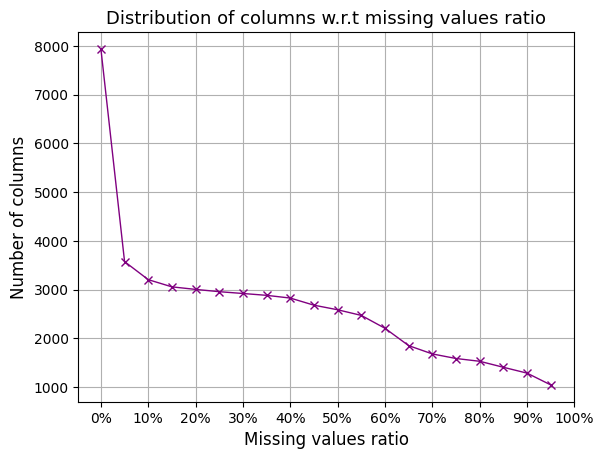

In [13]:
plt.plot(thresholds, columns_distribution, marker="x", ls="-", lw = '1', color="purple")

plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [f"{x*10}%" for x in range(0, 11)])

plt.xlabel("Missing values ratio", fontsize=12)
plt.ylabel("Number of columns", fontsize=12)
plt.title("Distribution of columns w.r.t missing values ratio", fontsize=13)

plt.grid()
plt.show()

This graph highlights that our database presents many missing values. To conserve genetic data, we decide to drop all columns with a missing values ration greater than 65%.

However, attention is needed. The vast majority of the columns in our dataset are in fact timed realizations of one global variable. Take R1MSTAT for example. It appears that R1MSTAT, R2MSTAT, ..., R14MSTAT are the responses of individuals to the same question, say RwMSTAT, asked at different waves. Hence, it may make sense for these 14 variables to not be treated separately: if we delete R12MSTAT, we shall delete R1MSTAT, R2MSTAT, etc. If we keep one column, we keep all of them.

We shall then track which variables are like RwMSTAT.

In [14]:
temporal_variables = {}
columns = [col for col in data.columns if "genetic_" not in col and col[1] in "123456789"]
for col in columns:
  char = col[0]
  if col[2] in "01234":
    wave = col[1:3]
    suffix = col[3:]
  else:
    if col[2] in "56789":
      print(col)
      break
    wave = col[1]
    suffix = col[2:]
  variable = char + 'w' + suffix
  
  if variable in temporal_variables.keys():
    temporal_variables[variable].append(int(wave))
  else:
    temporal_variables[variable] = [int(wave)]


In [15]:
temporal_variables_NaN = {}
for var in temporal_variables.keys():
  temporal_variables_NaN[var] = np.empty((14))
  temporal_variables_NaN[var][:] = np.nan

print("Waves explored:", end=" ")
for wave in range(1, 15):
  wave_columns = [var for var in temporal_variables.keys() if wave in temporal_variables[var]]
  wave_columns_name = [col.replace('w', str(wave)) for col in wave_columns]
  data_wave = data.loc[data[f"INW{wave}"]==1, wave_columns_name]
  data_wave_NaN = data_wave.isna().sum()/data_wave.shape[0]
  
  for var in wave_columns:
    temporal_variables_NaN[var][wave-1] = data_wave_NaN[var.replace('w', str(wave))]
  print(wave, end=" ")

temporal_variables_NaN = pd.DataFrame(temporal_variables_NaN)

Waves explored: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

In [16]:
temporal_variables_NaN

,RwMSTAT,RwMPART,RwMRCT,RwMLEN,RwMCURLN,RwMLENM,RwMDIV,RwMWID,RwMNEV,RwMEND,...,RwADL5H,RwADL6A,RwADL6H,RwIADL5H,RwINHPTN,RwHLPRTN,RwHLPDYST,RwHLPHRST,RwHLPPDTN,RwHLPPDTA
0,0.000000,0.0,0.003003,0.0,0.193013,0.0,0.0,0.0,0.000000,0.003003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.0,0.003462,0.0,0.310203,0.0,0.0,0.0,0.000000,0.003462,...,0.0,0.581458,0.581407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003502,0.0,0.003335,0.0,0.321049,0.0,0.0,0.0,0.000000,0.003335,...,0.0,0.002168,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001122,0.0,0.002853,0.0,0.334409,0.0,0.0,0.0,0.000140,0.002853,...,0.0,0.001450,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001022,0.0,0.003014,0.0,0.350495,0.0,0.0,0.0,0.000102,0.003014,...,0.0,0.001430,0.000000,0.0,0.0,0.003320,0.005516,0.013076,0.866074,0.004699
5,0.000826,0.0,0.003193,0.0,0.371208,0.0,0.0,0.0,0.000055,0.003193,...,0.0,0.000551,0.000000,0.0,0.0,0.003193,0.004569,0.011340,0.857748,0.004459
6,0.000745,0.0,0.003130,0.0,0.365493,0.0,0.0,0.0,0.000099,0.003130,...,0.0,0.000646,0.000000,0.0,0.0,0.003925,0.005266,0.012370,0.865815,0.005018
7,0.000108,0.0,0.003249,0.0,0.379988,0.0,0.0,0.0,0.000108,0.003249,...,0.0,0.000704,0.000000,0.0,0.0,0.003357,0.004981,0.012074,0.855379,0.004927
8,0.000116,0.0,0.003369,0.0,0.394610,0.0,0.0,0.0,0.000058,0.003369,...,0.0,0.000639,0.000000,0.0,0.0,0.003136,0.004124,0.010919,0.853575,0.005111
9,0.000272,0.0,0.003585,0.0,0.397250,0.0,0.0,0.0,0.000091,0.003585,...,0.0,0.005991,0.000000,0.0,0.0,0.002768,0.005401,0.013888,0.847009,0.005945


In the dataframe above, the index corresponds to the wave - 1, and each case corresponds to the missing values rate for the observed variable during a specific rate.

We will delete all variables which present an average missing rate (average realized across all available waves) of at least 65%.

In [17]:
max_missing_values_rate = 0.65

In [18]:
print(f"There are {(temporal_variables_NaN.mean()>=max_missing_values_rate).sum()} variables with an average missing rate of more than {int(max_missing_values_rate*100)}%.")
print(f"It corresponds to {(~temporal_variables_NaN[[col for col in temporal_variables_NaN.columns if temporal_variables_NaN[col].mean()>=max_missing_values_rate]].isna()).sum().sum()} columns in our original dataset.")

There are 156 variables with an average missing rate of more than 65%.
It corresponds to 1577 columns in our original dataset.


In [19]:
# We collect columns to delete.
criteria = temporal_variables_NaN.mean()>=max_missing_values_rate
var_to_delete = list(criteria.index[criteria]) # Variables to delete

columns_to_delete = []
for var in var_to_delete:
  available_waves = list(temporal_variables_NaN.loc[~temporal_variables_NaN[var].isna(), var].index)
  for wave in available_waves:
    columns_to_delete.append(var.replace('w', str(wave+1)))

In [20]:
print("Before drop, data shape =", data.shape, end="\n\n")
data.info(memory_usage="deep")

Before drop, data shape = (42233, 7939)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 7939 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(7812), int64(111), object(16)
memory usage: 2.5 GB


We successfully dropped the temporal columns with a missing rate too high.

Remain the non-temporal columns.

In [21]:
columns = [col for col in data.columns if "genetic_" not in col and col[1] not in "123456789"]
len(columns)

335

In [22]:
columns_with_number = [col for col in columns if "1" in col or "2" in col or "3" in col or "4" in col or "5" in col or "6" in col or "7" in col or "8" in col or "9" in col]
data_with_number = data[columns_with_number]
missing_ratio_data_with_number = (data_with_number.isna().sum()/data_with_number.shape[0]).sort_values()
missing_ratio_data_with_number.to_dict()
criteria = (data_with_number.isna().sum()/data_with_number.shape[0]>= 0.65)
columns_to_delete += list(criteria.index[criteria])
columns_to_delete += ["RASPID1"] # Manually added, as it presents 26% of missing values but is a useless column.

In [23]:
columns_without_number = [col for col in columns if col not in columns_with_number and "FILEVER" not in col]
data_without_number = data[columns_without_number]
criteria = (data_without_number.isna().sum()/data_without_number.shape[0]>= 0.65)
columns_to_delete += list(criteria.index[criteria])

In [24]:
# Finally, we drop these columns
data = data.drop(columns=columns_to_delete)

print("After drop, data shape =", data.shape, end="\n\n")
print(data.info(memory_usage="deep"))

After drop, data shape = (42233, 6131)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 6131 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(6004), int64(111), object(16)
memory usage: 2.0 GB
None


The next step is to cast right dtypes: too many columns have been casted as float64, and some of them as object. Let us see if there is something we can do about it.

## Cast dtypes

In [25]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 6131 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(6004), int64(111), object(16)
memory usage: 2.0 GB


### Object dtypes

Only 16 columns have been casted as 'object'. Let us deal with them.

In [26]:
data.select_dtypes(include=["object"]).head()

,H1HHIDC,H2HHIDC,H3HHIDC,H4HHIDC,H5HHIDC,H6HHIDC,H7HHIDC,H8HHIDC,H9HHIDC,H10HHIDC,H11HHIDC,H12HHIDC,H13HHIDC,H14HHIDC,FILEVER,genetic_Section_A_or_E
0,0000010,0000010,.,.,.,.,.,.,.,.,.,.,.,.,U,NaN
1,0000020,0000020,0000020,0000020,0000020,.,.,.,.,.,.,.,.,.,U,NaN
2,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,.,.,.,U,E
3,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,.,.,U,E
4,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,.,U,NaN


In [27]:
data["genetic_Section_A_or_E"] = data["genetic_Section_A_or_E"].astype("category") # this variable only takes 'A' and 'E' as values.
data = data.drop("FILEVER", axis=1) # this variable does not give information (each row is 'U')
for i in range(1, 15):
  col = f"H{i}HHIDC"
  data[col] = data[col].replace("      .", np.nan).astype("float64") # We get rid of the '      .'.

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 6130 entries, HHIDPN to genetic_Section_A_or_E
dtypes: category(1), float64(6018), int64(111)
memory usage: 1.9 GB


### Int dtypes

In [29]:
data.select_dtypes(include=["int64"]).columns

Index(['HHIDPN', 'INW1', 'INW2', 'INW3', 'INW4', 'INW5', 'INW6', 'INW7',
       'INW8', 'INW9',
       ...
       'R5IADL5H', 'R6IADL5H', 'R7IADL5H', 'R8IADL5H', 'R9IADL5H', 'R10IADL5H',
       'R11IADL5H', 'R12IADL5H', 'R13IADL5H', 'R14IADL5H'],
      dtype='object', length=111)

In [30]:
data.select_dtypes(include=["int64"]).isna().sum().max()

0

As we could have guessed, there is no particular issue with these columns.

### Float dtypes

In [31]:
data_unique = data.nunique()/data.count()

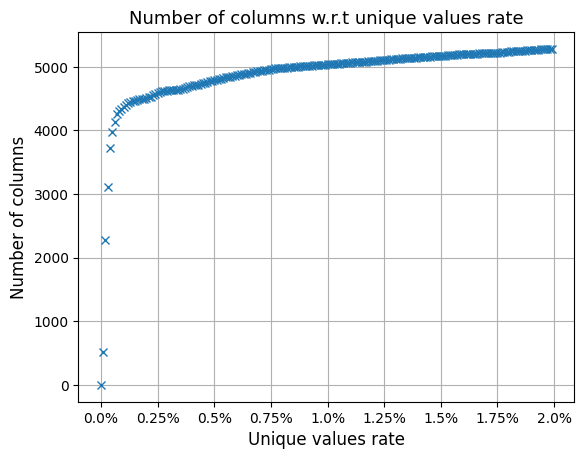

In [32]:
number_of_classes = np.arange(0, 2, 0.01)
percentages = []
for n in number_of_classes:
  percentages.append((data_unique<=n/100).sum())

plt.plot(number_of_classes, percentages, 'x')

x_ticks = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
plt.xticks(x_ticks, [f"{x}%" for x in x_ticks])

plt.xlabel("Unique values rate", fontsize=12)
plt.ylabel("Number of columns", fontsize=12)
plt.title("Number of columns w.r.t unique values rate", fontsize=13)

plt.grid()
plt.show()

This graph let us reckon that the most majority of columns present categorical variables (as of the low number of different values).

For future exploration of our database, we need to be aware of the type of each column. One may try to infer it with respect to the number of unique values each column take, and although this approach might prove itself right most of the time, it would cast numeric data to categorical ones or the other way around without any way for us to be informed of that. Hence, we will need to find another way to proceed. This will be the subject of the next notebook.

## Save the database

In [33]:
data.to_csv("first_drop_data.csv", index=False)